In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [113]:
log = open('../target/paxos.log', 'r')
lines = log.readlines()

In [114]:
rows = []

for line in lines:
    s = line.split(' ')
    if len(s) < 7 or s[0] != 'INFO': continue
    rows.append({'t': int(s[1]), 'test': s[2], 'pId': s[5], 'type': s[6]})

df = pd.DataFrame(rows)
dfd = df[df['type'] == 'Decided']
dfp = df[df['type'] == 'Propose']
dfm = dfd.merge(dfp, on=['test', 'pId'], validate='one_to_one')
dfm['t'] = dfm['t_x'] - dfm['t_y']
dfm = dfm.drop(['t_x', 't_y', 'type_x', 'type_y'], axis=1)
dfm = dfm.groupby('test', as_index=False).agg({'test': 'first', 't': min})
dfm[['n', 'f', 'a', 'timeout', 'iter']] = dfm['test'].str.split('-', expand=True)
dfm = dfm.drop(['test'], axis=1)
dfm['std'] = dfm['t']
dfm

,t,n,f,a,timeout,iter,std
0,998,100,49,0,1000,0,998
1,1002,100,49,0,1000,1,1002
2,994,100,49,0,1000,2,994
3,188,100,49,0,1000,3,188
4,983,100,49,0,1000,4,983
...,...,...,...,...,...,...,...
395,629,75,37,100,500,0,629
396,506,75,37,100,500,1,506
397,238,75,37,100,500,2,238
398,991,75,37,100,500,3,991


In [116]:
df_avg = dfm.groupby(['n', 'f', 'a', 'timeout'], as_index=False).agg({'t': sum, 'std': np.std})
df_avg['t'] /= 5
df_avg = df_avg.astype({'n':'int64', 'f':'int64', 'a':'int64', 'timeout':'int64'})
df_avg

,n,f,a,timeout,t,std
0,100,49,0,1000,833.0,360.635550
1,100,49,0,1500,1499.0,6.708204
2,100,49,0,2000,1863.6,309.500889
3,100,49,0,500,496.4,2.880972
4,100,49,1,1000,1149.8,107.606691
...,...,...,...,...,...,...
75,75,37,10,500,516.0,298.807630
76,75,37,100,1000,613.4,517.641575
77,75,37,100,1500,1695.0,285.467161
78,75,37,100,2000,2175.6,230.880489


In [117]:
df_avg.to_csv('df_5avg.csv')

In [88]:
timeouts = df_avg['timeout'].unique()
timeouts.sort()
crash_ps = df_avg['a'].unique()
crash_ps.sort()
ns = df_avg['n'].unique()
ns.sort()

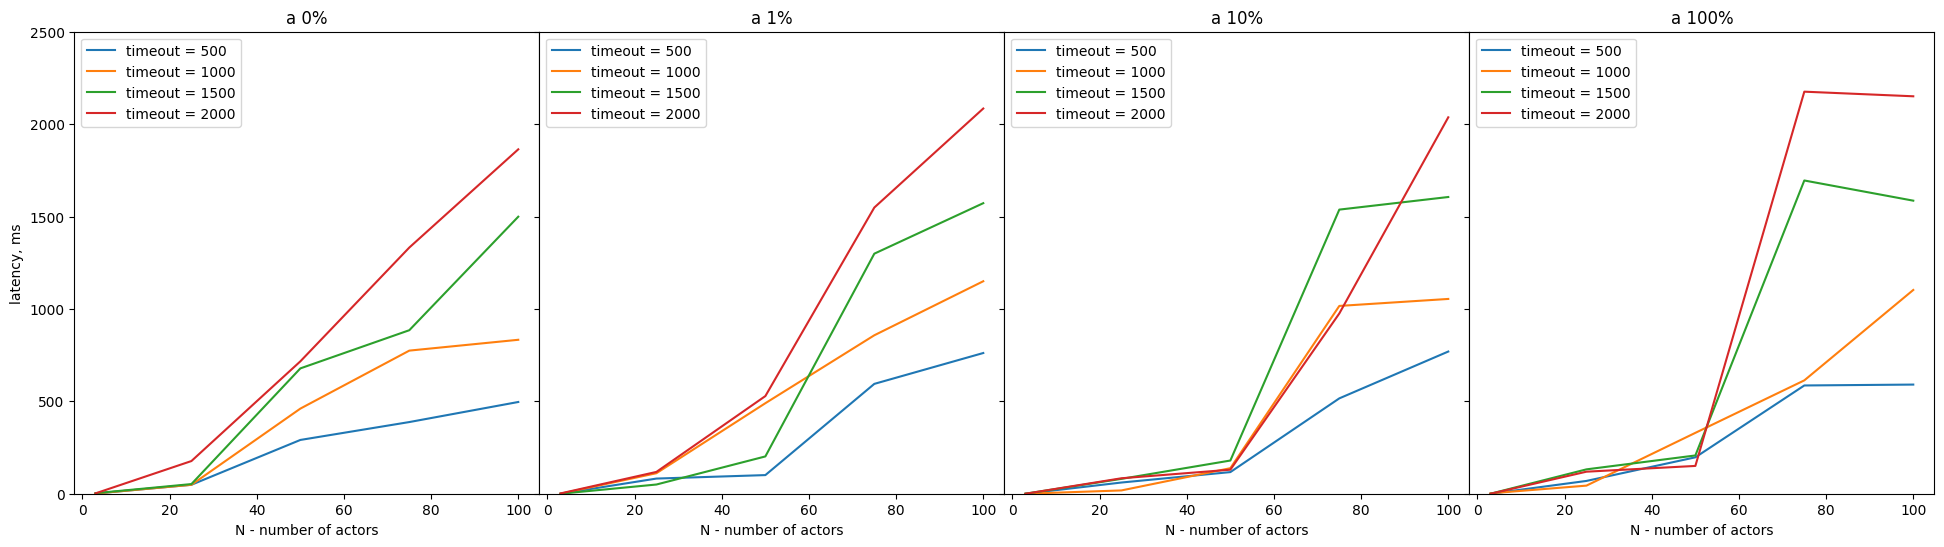

In [133]:
fig, ax = plt.subplots(1, 4, figsize=(24, 24 / 4), sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].set_ylabel('latency, ms')
for i, a in enumerate(crash_ps):
    box = ax[i]
    for j, timeout in enumerate(timeouts):
        data = df_avg[(df_avg['a']==a) & (df_avg['timeout']==timeout)].sort_values(by='n')
        box.plot(data['n'], data['t'], label=f'timeout = {timeout}')
        box.set_xlabel('N - number of actors')
        box.set_ylim(0, 2500)
        box.set_title(f'a {a}%')
    box.legend(loc='upper left')

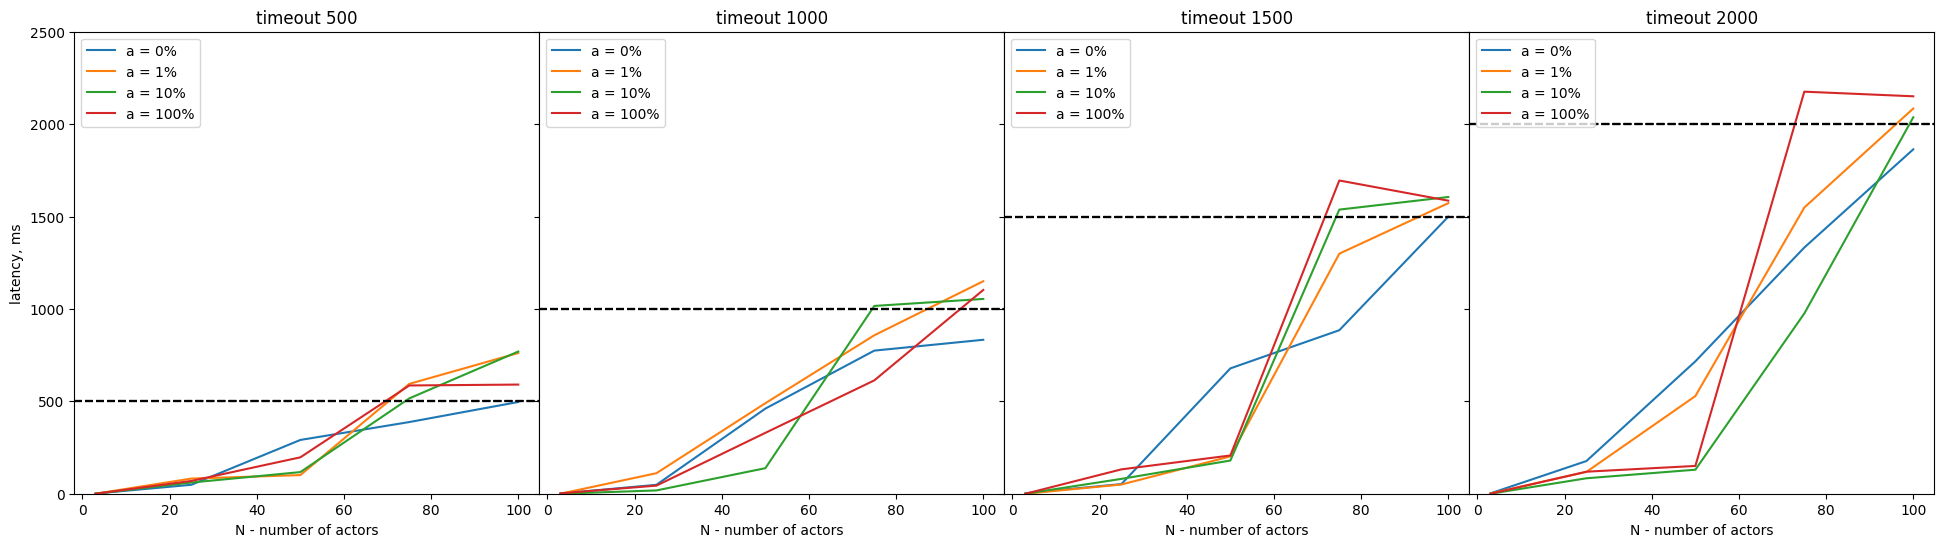

In [138]:
fig, ax = plt.subplots(1, 4, figsize=(24, 24 / 4), sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].set_ylabel('latency, ms')
for i, timeout in enumerate(timeouts):
    box = ax[i]
    for j, a in enumerate(crash_ps):
        data = df_avg[(df_avg['timeout']==timeout) & (df_avg['a']==a)].sort_values(by='n')
        box.plot(data['n'], data['t'], label=f'a = {a}%')
        box.set_xlabel('N - number of actors')
        box.set_ylim(0, 2500)
        box.set_title(f'timeout {timeout}')
        box.axhline(y = timeout, color = 'black', linestyle = '--')
    box.legend(loc='upper left')
plt.savefig('plots.pdf', bbox_inches='tight')
plt.savefig('plots.png', bbox_inches='tight')